In [35]:
import re
import os
import anndata
import scanpy as sc
import pandas as pd
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
from skimage.transform import rescale, resize
from skimage.color import label2rgb
from pathlib import Path

In [33]:
figure_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/neha_imc/figures'
Path(figure_dir).mkdir(parents=True, exist_ok=True)

In [5]:
gates = pd.read_csv('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/neha_imc/data/QiGates.csv',
                    index_col='Cell')
gates

,SMA,PanCK,CD68,CD8,HH3,CD163
Cell,,,,,,
1,0,0,1,1,1,0
2,1,1,1,1,1,0
3,1,1,1,1,1,1
4,1,1,1,1,1,0
5,1,0,1,1,1,0
...,...,...,...,...,...,...
7531,1,0,1,0,1,0
7532,0,0,1,0,1,1
7533,1,0,1,0,1,0


In [6]:
features = pd.read_csv('/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/neha_imc/data/ROI001_ROI_001_QiFeaturesToOrange.csv',
                       index_col='Cell Id')
features

,X,Y,Yinv,DNAmean,DNAkurt,141Pr_141Pr-SMA,141Pr_141Pr-SMA Nuc/Cyto,147Sm_147Sm-CD163,147Sm_147Sm-CD163 Nuc/Cyto,148Nd_148Nd-PanK,148Nd_148Nd-PanK Nuc/Cyto,159Tb_159Tb-CD68,159Tb_159Tb-CD68 Nuc/Cyto,162Dy_162Dy-CD8a,162Dy_162Dy-CD8a Nuc/Cyto,176Yb_176YbHistoneH3,176Yb_176YbHistoneH3 Nuc/Cyto
Cell Id,,,,,,,,,,,,,,,,,
1,1060.539185,735.099976,420.899994,110.069565,1.291817,55.121807,11.203725,0.133595,2.373346,0.104126,1.848447,11.239686,1.845494,0.589391,0.915103,19.328094,0.961505
2,401.683929,231.461136,924.538879,97.746117,3.244834,45.320328,8.963617,0.199179,1.620549,6.447639,0.210360,10.564682,1.188608,0.572895,0.933361,29.887064,0.815735
3,118.838486,944.137451,211.862549,84.178696,9.776967,44.102341,5.834608,0.349415,1.723515,4.226608,0.261516,12.014620,1.336131,1.970760,0.688113,18.007311,1.175574
4,1091.227051,336.361969,819.638062,71.276077,-0.186355,41.143276,5.201149,0.166667,2.031595,3.959064,0.064396,7.964912,0.888153,0.573099,0.651753,24.789474,0.865603
5,134.937500,1088.539062,67.460938,81.750000,2.769130,34.462566,8.292990,0.125668,1.552284,0.294118,1.098214,6.385027,1.997371,0.430481,0.997199,23.283422,4.271940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,1024.000000,1154.000000,2.000000,53.000000,0.000000,17.857143,3.497462,0.000000,0.000000,0.071429,0.000000,5.642857,2.102941,0.214286,0.000000,5.714286,1.444444
7532,56.000000,219.000000,937.000000,42.000000,0.000000,6.127273,7.688136,0.472727,0.000000,0.145455,0.000000,4.763637,1.482353,0.109091,0.000000,14.654546,3.724138
7533,1051.000000,1154.000000,2.000000,48.000000,0.000000,29.000000,1.979381,0.000000,0.000000,0.200000,0.000000,5.800000,0.000000,0.200000,0.000000,5.000000,1.882353


In [42]:
def call_cells(gates):
    cell_types = np.asarray(['Unknown'] * gates.shape[0], dtype=object)
    
    cell_types[gates['SMA']==1] = 'Fibroblast'
    cell_types[gates['CD68']==1] = 'Macrophage - M1'
    cell_types[gates['CD163']==1] = 'Macrophage - M2'
    cell_types[gates['CD8']==1] = 'CD8 T cell'
    cell_types[gates['PanCK']==1] = 'Tumor'
    
    return cell_types

In [43]:
features['cell_type'] = call_cells(gates)

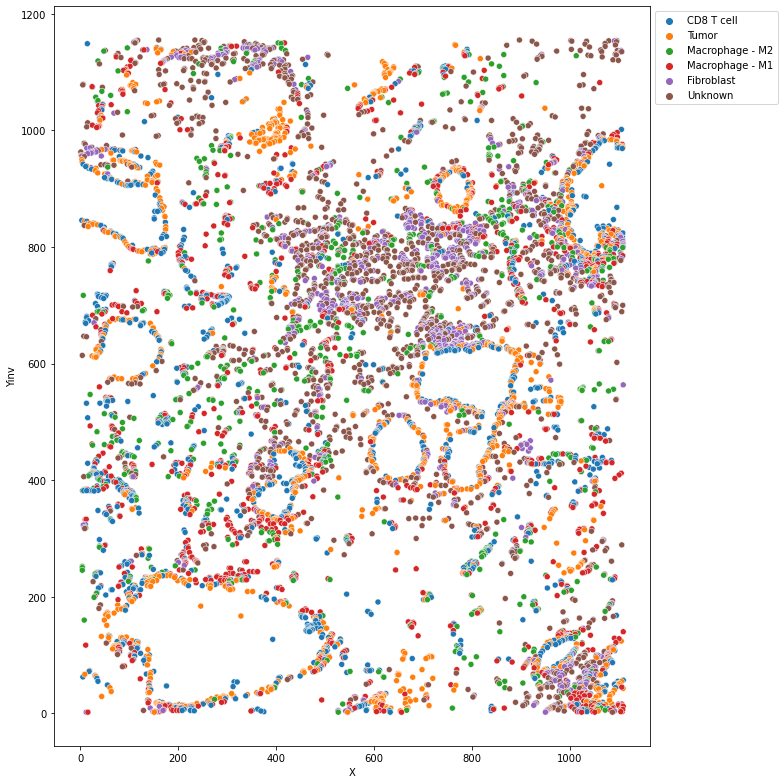

In [44]:
r_max, c_max = max(features['Yinv']), max(features['X'])
fig, ax = plt.subplots(figsize=(int(r_max / 100), int(c_max / 100)))
sns.scatterplot(data=features, x='X', y='Yinv', hue='cell_type', ax=ax)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'mapped_cell_types.png'))

In [45]:
channels = [c for c in features.columns if re.findall(r'^[0-9]+[^ ]*$', c)]
channels
adata = anndata.AnnData(X=features[channels].values, obs=features)
adata.var.index = channels
adata.obsm['spatial'] = features[['Yinv', 'X']].values
adata.strings_to_categoricals()
adata

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  This is separate from the ipykernel package so we can avoid doing imports until
/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 7535 × 6
    obs: 'X', 'Y', 'Yinv', 'DNAmean', 'DNAkurt', '141Pr_141Pr-SMA', '141Pr_141Pr-SMA Nuc/Cyto', '147Sm_147Sm-CD163', '147Sm_147Sm-CD163 Nuc/Cyto', '148Nd_148Nd-PanK', '148Nd_148Nd-PanK Nuc/Cyto', '159Tb_159Tb-CD68', '159Tb_159Tb-CD68 Nuc/Cyto', '162Dy_162Dy-CD8a', '162Dy_162Dy-CD8a Nuc/Cyto', '176Yb_176YbHistoneH3', '176Yb_176YbHistoneH3 Nuc/Cyto', 'cell_type'
    obsm: 'spatial'

In [46]:
sq.gr.co_occurrence(adata, cluster_key="cell_type", n_splits=1, n_jobs=40)

  0%|          | 0/1 [00:00<?, ?/s]

ERROR: Unable to fetch palette, reason: 'cell_type_colors'. Using `None`.


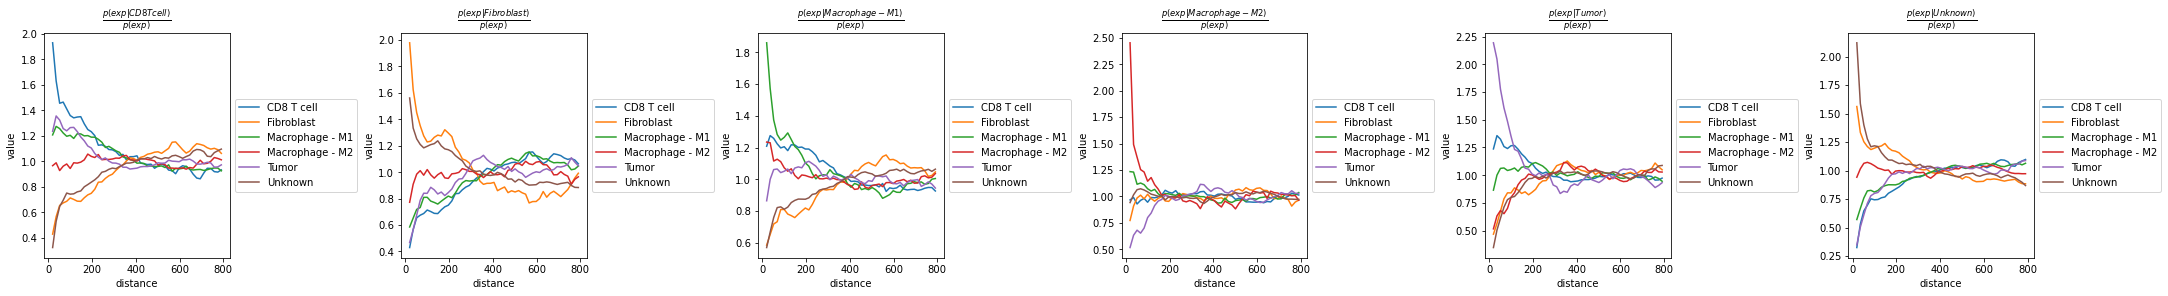

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [53]:
sq.pl.co_occurrence(
    adata,
    cluster_key="cell_type",
    clusters=set(adata.obs['cell_type']),
    figsize=(30, 4),
    save=os.path.join(figure_dir, 'spatial_co_occurance.pdf')
)

In [48]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cell_type")

  0%|          | 0/1000 [00:00<?, ?/s]

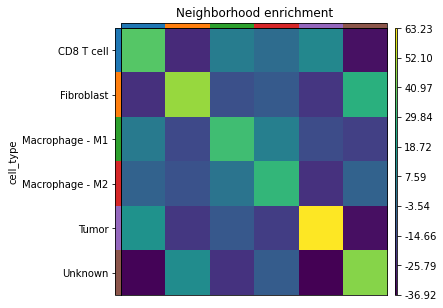

In [49]:
sq.pl.nhood_enrichment(adata, cluster_key="cell_type",
                      save=os.path.join(figure_dir, 'nhood_enrichment.pdf'))

In [50]:
sq.gr.interaction_matrix(adata, cluster_key="cell_type")

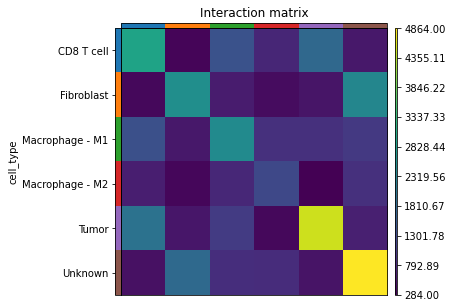

In [51]:
sq.pl.interaction_matrix(adata, cluster_key="cell_type",
                        save=os.path.join(figure_dir, 'interaction_matrix.pdf'))

In [52]:
adata.write_h5ad(os.path.join(figure_dir, 'spatial_analysis.h5ad'))